# IMPORTS
## DATA SCIENCE PACKAGES

In [6]:
# Import des librairies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import pickle
import time
import string
import logging
logging.disable(logging.WARNING)

In [7]:
import math



In [8]:
import re
# as per recommendation from @freylis, compile once only
CLEANR = re.compile('<(?s:.)*?>') 

## TEXT PROCESSING PACKAGES

In [9]:
import nltk
from nltk.stem import WordNetLemmatizer

## sklearn modeling packages

In [10]:
from sklearn import cluster, metrics, preprocessing, manifold, decomposition, model_selection
from sklearn import svm
from sklearn.svm import SVC #Linear SVC would have been the simpler linear version
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import auc, roc_curve, confusion_matrix, SCORERS, accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import RocCurveDisplay

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [12]:
path = '/Users/souha_kassab/OC_P5/static/csv/'

## Prepare Data

### Import corpus

In [13]:
shuffled_data = pd.read_csv(path + 'REDUCED_Multiclass_data_80pcent_tags.csv', index_col=[0], low_memory=False)
shuffled_data = shuffled_data.sample(frac=1)

In [14]:
# METHOD TO COMPUTE MEMORY USAGE DURING AN OPERATION
BYTES_TO_MB_DIV = 0.000001
def print_memory_usage_of_data_frame(df):
    mem = round(df.memory_usage().sum() * BYTES_TO_MB_DIV, 3) 
    print("Memory usage is " + str(mem) + " MB")
    
print_memory_usage_of_data_frame(shuffled_data)

Memory usage is 0.272 MB


In [15]:
import ast
shuffled_data['Tags_words'] = shuffled_data['Tags_words'].apply(lambda x: ast.literal_eval(x))

In [16]:
shuffled_data.head()

,AnswerCount,Tags_words,unique_commn_tag,unique_rare_tag,Title_bow,Body_bow,Body_bow_lem,Title_bow_lem,unique_tag,concatenated_query_bow_lem
42017,2,"[python, sql-server, pandas, python-2.7, hive]",python,hive,performance issue reading data hive using python,table hive 351 837 110 size records reading ta...,table hive 351 837 110 size record reading tab...,performance issue reading data hive using python,python,performance issue reading data hive using pyth...
33074,6,"[c#, .net, email, smtp, gmail]",c#,smtp,gmail how send email programmatically,possible exact duplicate sending email .net th...,possible exact duplicate sending email .net gm...,gmail send email programmatically,c#,gmail send email programmatically possible exa...
47137,3,"[c, linux, unix, keyboard, signal-handling]",c,signal-handling,get keyboard interrupt,program include stdio.h void main int time=180...,program include stdio.h void main int time=180...,get keyboard interrupt,c,get keyboard interrupt program include stdio.h...
41912,4,"[java, spring-boot, kubernetes, minikube, conf...",java,configmap,can read configmap name namespace 'default ign...,new k8s.trying read values profile based confi...,new k8s.trying read value profile based config...,read configmap name namespace 'default ignoring,java,read configmap name namespace 'default ignorin...
14218,3,"[jquery, ajax, security, forms, post]",jquery,post,securing jquery ajax calls,recently started digging jquery ajax function ...,recently started digging jquery ajax function ...,securing jquery ajax call,jquery,securing jquery ajax call recently started dig...


### Inspect data

<Axes: ylabel='count'>

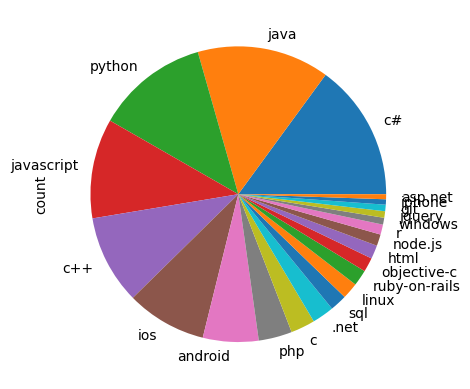

In [17]:
shuffled_data['unique_tag'].value_counts().plot(kind='pie')

### Split data

In [18]:
X = shuffled_data['concatenated_query_bow_lem']
y = shuffled_data['unique_tag']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42, stratify=y)
print(X_train.shape, X_test.shape)

(2163,) (927,)


In [19]:
print(sorted(y_train.unique()))

['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'git', 'html', 'ios', 'iphone', 'java', 'javascript', 'jquery', 'linux', 'node.js', 'objective-c', 'php', 'python', 'r', 'ruby-on-rails', 'sql', 'windows']


In [20]:
print(sorted(y_test.unique()))

['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'git', 'html', 'ios', 'iphone', 'java', 'javascript', 'jquery', 'linux', 'node.js', 'objective-c', 'php', 'python', 'r', 'ruby-on-rails', 'sql', 'windows']


In [21]:
print(y_train.head(), 
      '\n', y_test.head())

29852             java
45687          node.js
11775    ruby-on-rails
19626           python
19233              c++
Name: unique_tag, dtype: object 
 37722          java
1366        android
48465            c#
23634    javascript
21861        python
Name: unique_tag, dtype: object


### Features engineering

In [22]:
# BAG OF WORDS INSTANCE
bow_vect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
# TF-IDF INSTANCE
tf_vect = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

bow_fit = bow_vect.fit(X_train)
tf_fit = tf_vect.fit(X_train)
#bow_fit.get_feature_names_out()
#print(tf_fit.get_feature_names_out())
tf_fit.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.95,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

### Normalize data

In [23]:
bow_transform = bow_fit.transform(X_train)  
tf_transform = tf_fit.transform(X_train) 
tf_transform
#tf_transform.todense()

<2163x32801 sparse matrix of type '<class 'numpy.float64'>'
	with 141740 stored elements in Compressed Sparse Row format>

In [24]:
# display the document-term matrix
vocab = tf_fit.get_feature_names_out()
def densify(tfidf_vector, features):
    docterm = pd.DataFrame(tfidf_vector.todense(), columns=features)
    print(docterm.info() )
    return docterm

X_train_dense = densify(tf_transform, vocab)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2163 entries, 0 to 2162
Columns: 32801 entries, 00 to 읿r
dtypes: float64(32801)
memory usage: 541.3 MB
None


In [25]:
X_test_dense = densify(tfidf_vector=tf_fit.transform(X_test), features=vocab)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927 entries, 0 to 926
Columns: 32801 entries, 00 to 읿r
dtypes: float64(32801)
memory usage: 232.0 MB
None


In [31]:
skf = StratifiedKFold(n_splits=5)
X = shuffled_data['concatenated_query_bow_lem']
y = shuffled_data['unique_tag']
stratify_metrics = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
   # print(f"Fold {i}:")
   # print(f"  Train: index={train_index}")
   # print(f"  Test:  index={test_index}")
    vect = CountVectorizer(ngram_range=(1,2), max_features=1000 , stop_words="english")
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)

    stratify_metrics.append(accuracy_score(y_test, y_pred_class))

metrics = np.array(stratify_metrics)
print('Mean accuracy: ', np.mean(stratify_metrics, axis=0))
print('Std for accuracy: ', np.std(stratify_metrics, axis=0))

Mean accuracy:  0.5459546925566344
Std for accuracy:  0.01046664183093608


# Models comparison

In [26]:
def train_eval_model(model, X_train, y_train, X_test, y_test): 
    pipe = (model["classif"])
    start_time = time.time()
    # Fit model
    pipe.fit(X_train, y_train)
    print(pipe.get_params())
    
    # Check model
    train_predictions = pipe.predict(X_train)
    train_time = time.time() - start_time
    train_acc = accuracy_score(y_train, train_predictions)
    # Evaluate model
    test_predictions = pipe.predict(X_test)
    test_acc = accuracy_score(y_test, test_predictions)

    print(f'model {pipe} accuracy score on train set: {train_acc}; on test set: {test_acc}')

In [163]:
# Models to train 
models = [{"name": "Dummy Regressor", "classif": DummyClassifier()},
    {"name": "Decision Tree", "classif": DecisionTreeClassifier()},
    {"name": "Logistic Regressor", "classif": LogisticRegression(solver='lbfgs',max_iter=1000)},
         ]
trained_models = []
for model in models:
    # Fit model
    model_details = train_eval_model(model, X_train_dense, y_train, X_test_dense, y_test) 
    trained_models.append(model_details)
trained_models

{'constant': None, 'random_state': None, 'strategy': 'prior'}
model DummyClassifier() accuracy score on train set: 0.14932963476652797; on test set: 0.1499460625674218
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
model DecisionTreeClassifier() accuracy score on train set: 1.0; on test set: 0.5555555555555556
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
model LogisticRegression(max_iter=1000) accuracy score on train set: 0.7910309754969949; on test set: 0.6192017259978425


[None, None, None]

LR seems to be performing better than decision tree as per accuracy, however LR is more sensitive to outliers than SVM

In [ ]:
def train_eval_model(model, X_train, y_train, X_test, y_test): 
    pipe = (model["classif"])
    start_time = time.time()
    # Fit model
    pipe.fit(X_train, y_train)
    print(pipe.get_params())
    
    # Check model
    train_predictions = pipe.predict(X_train)
    train_time = time.time() - start_time    
    train_acc = accuracy_score(y_train, train_predictions)  
  
    # Evaluate model
    test_predictions = pipe.predict(X_test)
    test_acc = accuracy_score(y_test, test_predictions)
    #test_predicted_proba = pipe.predict_proba(X_test)
    #
   
    #test_MCM = multilabel_confusion_matrix(y_test, test_predictions)
    
   # test_F1 = (y_test, test_predictions)
    #test_report = classification_report(y_test, test_predictions)
     # initialize data of lists.
    metrics = {'Metrics_name': ['F1', 'classification_report', 'accuracy'],
        'Metric_value': [, , ]}
    test_metrics = pd.DataFrame(metrics)
    test_metrics = test_metrics.set_index('Metrics_name')
#RMSLE
    
    model_details = {"name": model["name"], "train_set_metrics":train_metrics, "test_set_metrics":test_metrics,
                     "train_time": train_time, "model": pipe}
    return model_details

## Cross-validation

In [164]:
def cross_eval_lr():
    crossval_estimator = LogisticRegression(max_iter=1000)
    crossval_params = {'C': np.logspace(-3, 3, 5),
              'penalty': ['l1', 'l2'],
              'solver': ['newton-cg', 'liblinear', 'lbfgs']

    }
    cv_grid = GridSearchCV(estimator=crossval_estimator,
                    params=crossval_params,
                    cv=3,
                    n_jobs=-1,
                    return_train_score=True,
                    verbose =0
                       )
    cv_grid.fit(X_train_dense, y_train) 
    best_params= cv_grid.best_params
    return cv_grid, best_params

In [44]:
def fancy_results(grid):
    res = pd.DataFrame(grid.cv_results_) 
    cols = [i for i in res.columns if "split" not in i]
    res = res[cols]
    res = res.sort_values("rank_test_score")
    
    return res

In [37]:
grid, cv_bestparams = cross_eval_lr()
#fancy_results(cv_grid)


/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
21 fits failed out of a total of 42.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/souha_kassab/opt/miniconda3/envs

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True)

In [ ]:
skf = StratifiedKFold(n_splits=5)

lst_accu_stratified = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lr.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(lr.score(x_test_fold, y_test_fold))
    
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
  max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
  min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
  mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

## Fit chosen model

In [165]:
#best_params= grid.best_params_
cross_validated_lr = LogisticRegression(penalty='l2', C=1000)
cross_validated_lr.fit(X_train_dense, y_train)

#train_eval_model(cross_validated_lr, X_train_dense, y_train, X_test_dense, y_test)


/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1000)

In [166]:
#PREDICT
test_predictions = cross_validated_lr.predict(X_test_dense)

# Metrics
## Confusion matrix

In [167]:
print(type(cross_validated_lr).__name__)    
print("----------------------------------")
print("Confusion matrix:") # GIVEN IN SORTED ORDER
print(multilabel_confusion_matrix(y_test, test_predictions))

LogisticRegression
----------------------------------
Confusion matrix:
[[[901   4]
  [ 21   1]]

 [[858  13]
  [ 17  39]]

 [[922   0]
  [  5   0]]

 [[893   9]
  [ 20   5]]

 [[709  79]
  [ 28 111]]

 [[799  38]
  [ 22  68]]

 [[918   2]
  [  4   3]]

 [[911   2]
  [  9   5]]

 [[820  26]
  [ 16  65]]

 [[922   0]
  [  5   0]]

 [[742  51]
  [ 39  95]]

 [[778  48]
  [ 15  86]]

 [[920   0]
  [  7   0]]

 [[907   3]
  [ 14   3]]

 [[913   2]
  [  5   7]]

 [[912   1]
  [ 14   0]]

 [[889   4]
  [ 15  19]]

 [[787  26]
  [ 26  88]]

 [[917   0]
  [ 10   0]]

 [[909   2]
  [  7   9]]

 [[905   5]
  [ 11   6]]

 [[920   0]
  [  5   2]]]


In [168]:
MCM = multilabel_confusion_matrix(y_test, test_predictions)
n_classes = len(y_test.unique())
y_labels  = list(sorted(y_test.unique()))
y_labels

['.net',
 'android',
 'asp.net',
 'c',
 'c#',
 'c++',
 'git',
 'html',
 'ios',
 'iphone',
 'java',
 'javascript',
 'jquery',
 'linux',
 'node.js',
 'objective-c',
 'php',
 'python',
 'r',
 'ruby-on-rails',
 'sql',
 'windows']

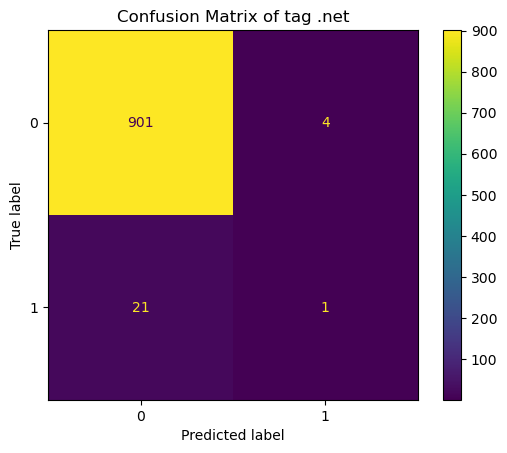

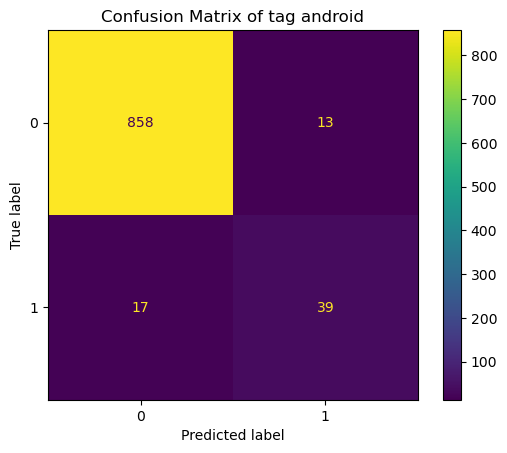

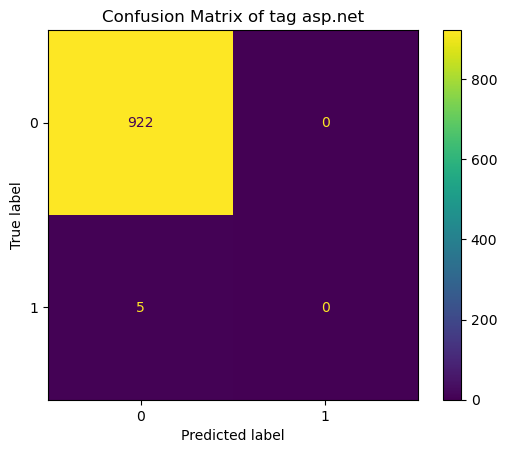

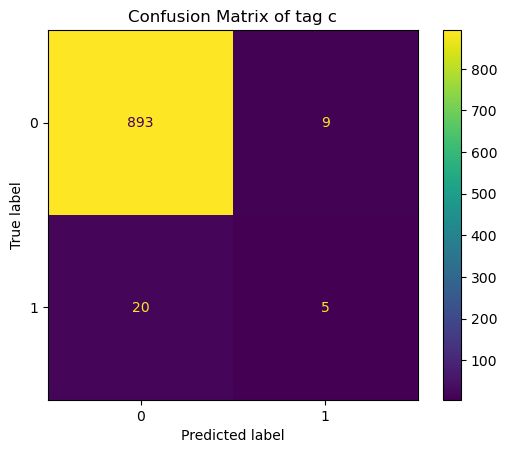

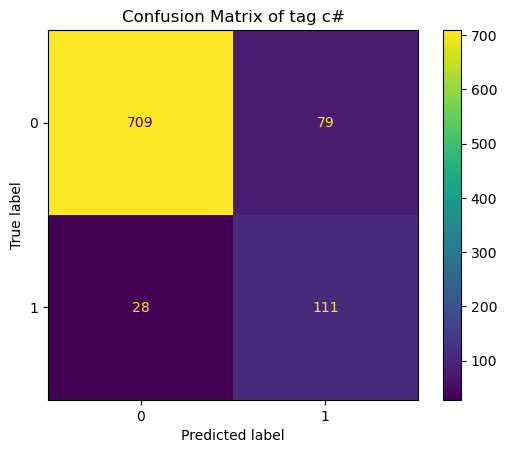

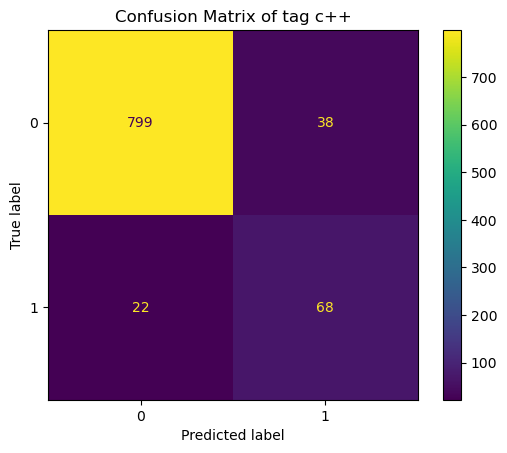

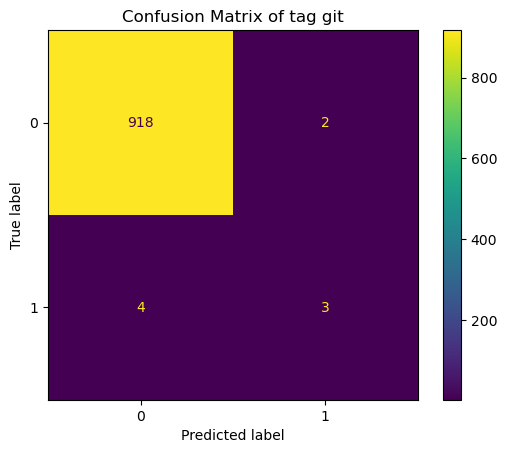

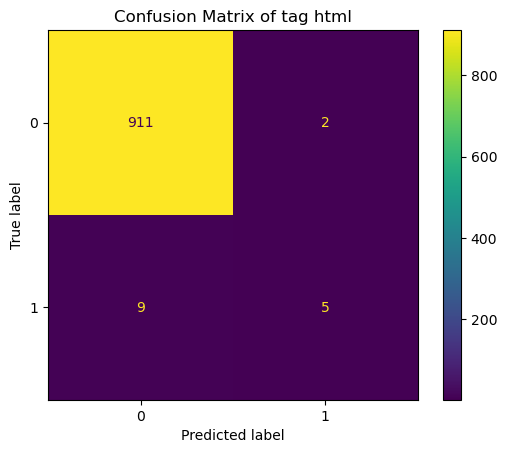

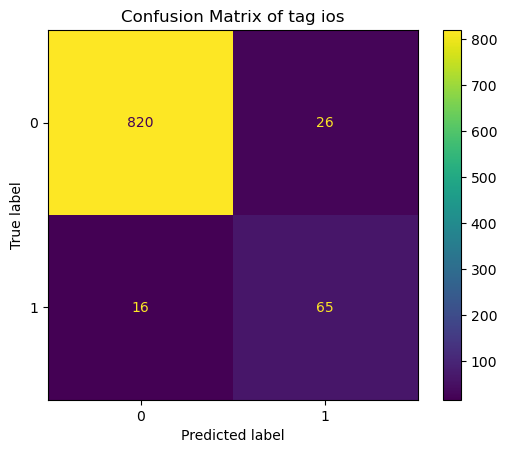

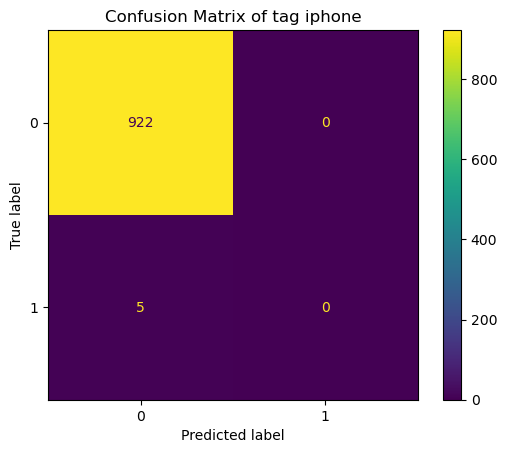

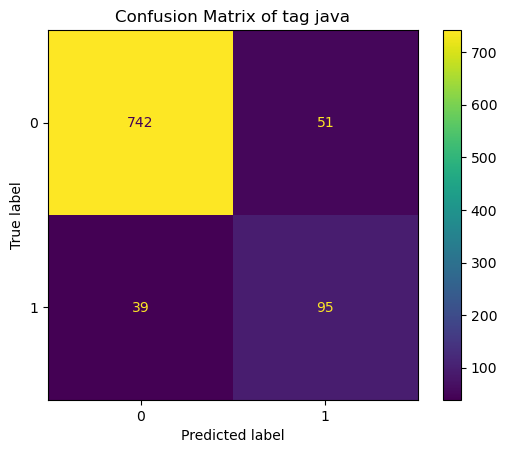

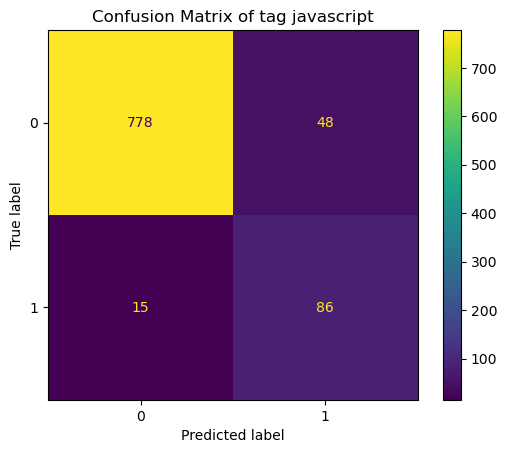

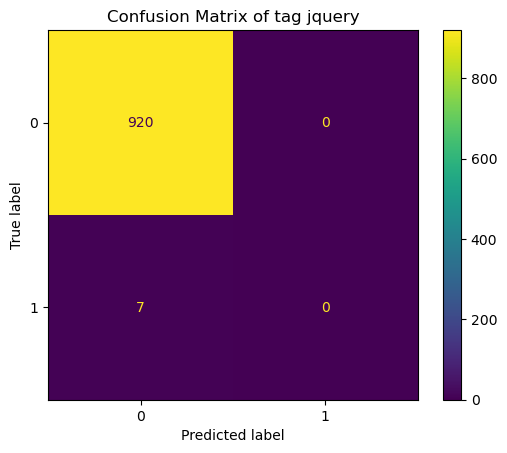

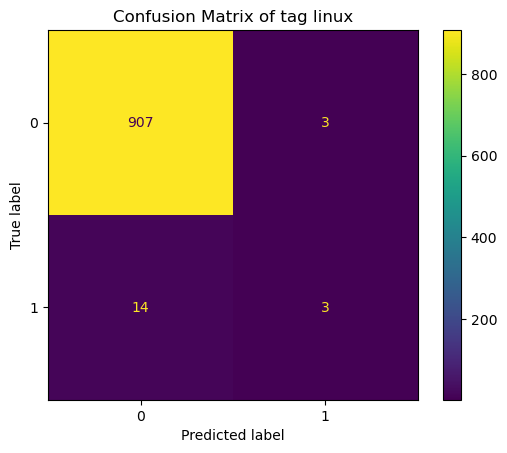

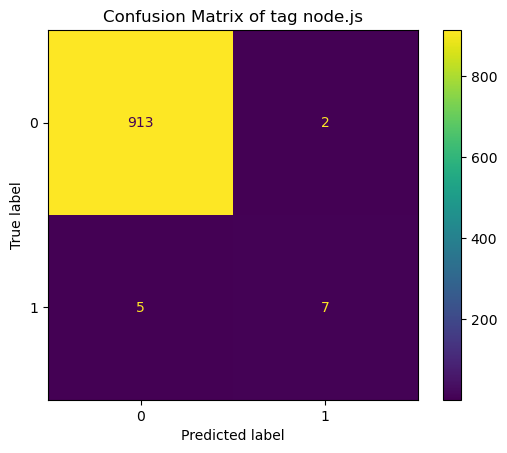

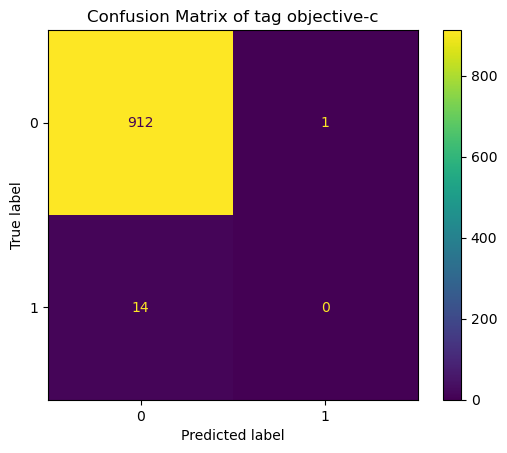

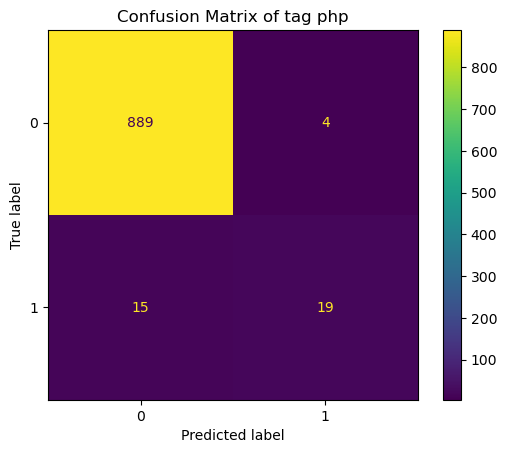

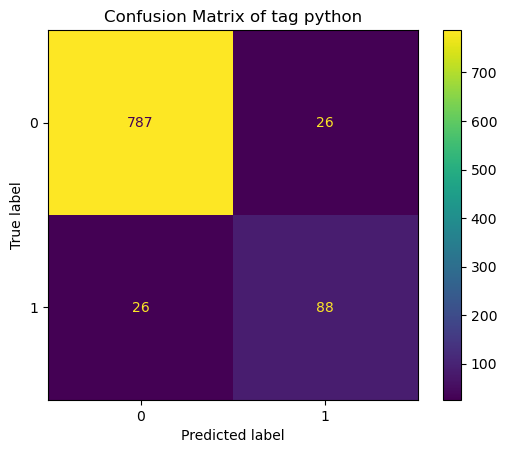

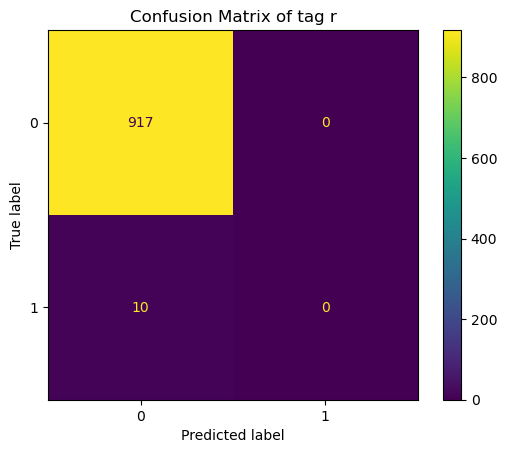

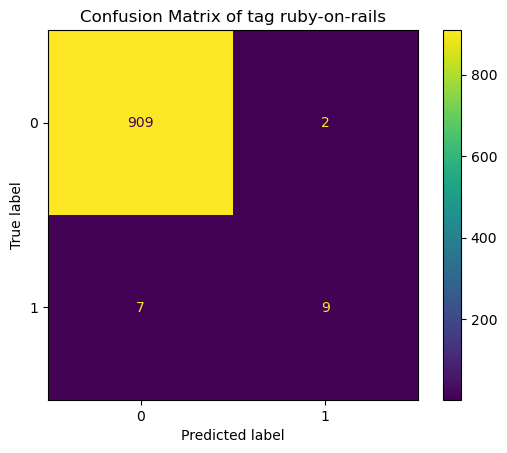

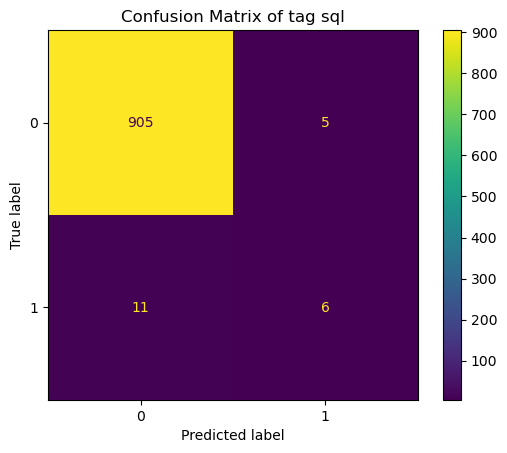

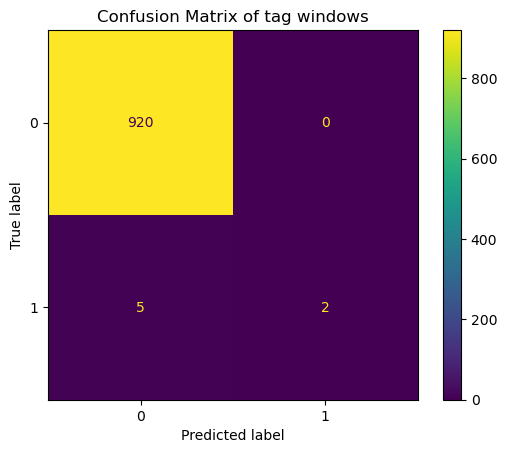

In [169]:
# Plotting matrices: code

for ntag in range(0, n_classes):
    cmd = ConfusionMatrixDisplay(MCM[ntag]).plot()
    plt.title(f'Confusion Matrix of tag {y_labels[ntag]}')
    plt.show()
    
    

In [73]:
len(y_labels)

22

## Classification report

In [170]:
print("\nClassification report:")
print(classification_report(y_test, test_predictions))


Classification report:
               precision    recall  f1-score   support

         .net       0.20      0.05      0.07        22
      android       0.75      0.70      0.72        56
      asp.net       0.00      0.00      0.00         5
            c       0.36      0.20      0.26        25
           c#       0.58      0.80      0.67       139
          c++       0.64      0.76      0.69        90
          git       0.60      0.43      0.50         7
         html       0.71      0.36      0.48        14
          ios       0.71      0.80      0.76        81
       iphone       0.00      0.00      0.00         5
         java       0.65      0.71      0.68       134
   javascript       0.64      0.85      0.73       101
       jquery       0.00      0.00      0.00         7
        linux       0.50      0.18      0.26        17
      node.js       0.78      0.58      0.67        12
  objective-c       0.00      0.00      0.00        14
          php       0.83      0.56      

/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [80]:
y_train.unique()

array(['c#', 'c++', 'python', 'javascript', 'java', 'android', 'c',
       'objective-c', 'ruby-on-rails', 'html', 'ios', '.net', 'sql', 'r',
       'php', 'asp.net', 'windows', 'linux', 'node.js', 'git', 'jquery',
       'iphone'], dtype=object)

Micro-averaging aggregates the contributions from all the classes (using np.ravel) to compute the average metrics as shown in : https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

## ROC, AUC
### Micro-averaged One-vs-Rest ROC AUC score

In [171]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_train = label_binarizer.transform(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape

(927, 22)

In [172]:
# TEST CELL
y_onehot_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [173]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.62


In [213]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["macro"], tpr["macro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.95


In [198]:
# PREDICT PROBABILITIES
y_score = cross_validated_lr.predict_proba(X_test_dense)
y_score

array([[3.04829886e-02, 1.76777686e-02, 8.00461808e-04, ...,
        2.01911463e-02, 1.10432669e-03, 1.07791114e-03],
       [2.37110513e-03, 7.14996525e-01, 8.76139221e-04, ...,
        1.97129314e-03, 4.26012547e-03, 1.23351918e-03],
       [5.72579150e-03, 9.82573054e-03, 3.11424311e-03, ...,
        7.28431655e-03, 3.07926459e-03, 1.11839026e-03],
       ...,
       [4.19868220e-04, 5.20235599e-04, 9.67634847e-05, ...,
        2.02334914e-04, 1.86439167e-04, 7.17862744e-05],
       [1.63932649e-02, 1.34732663e-03, 2.08884458e-04, ...,
        1.26691014e-03, 2.87737043e-03, 4.25322819e-04],
       [1.41755512e-02, 9.97496150e-04, 1.68485092e-03, ...,
        9.04610616e-04, 2.23499161e-03, 2.11776590e-02]])

### Multiclass Receiver Operating Characteristic (ROC)

In [199]:
label_binarizer.classes_

array(['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'git', 'html',
       'ios', 'iphone', 'java', 'javascript', 'jquery', 'linux',
       'node.js', 'objective-c', 'php', 'python', 'r', 'ruby-on-rails',
       'sql', 'windows'], dtype='<U13')

0


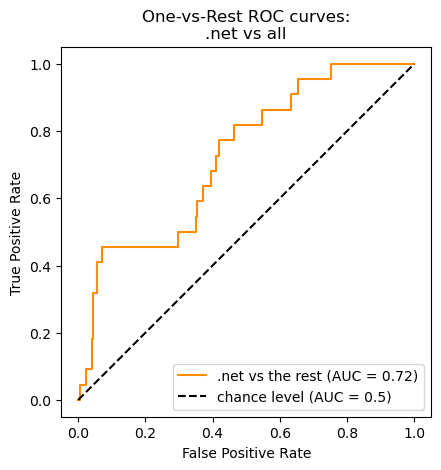

1


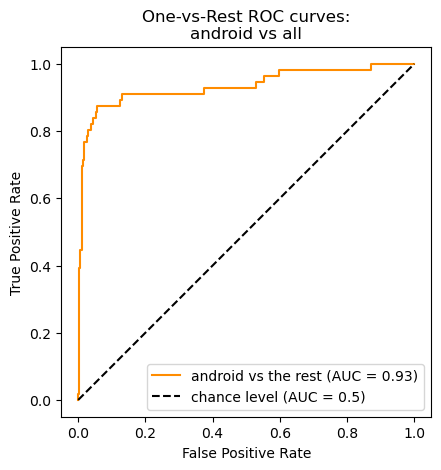

2


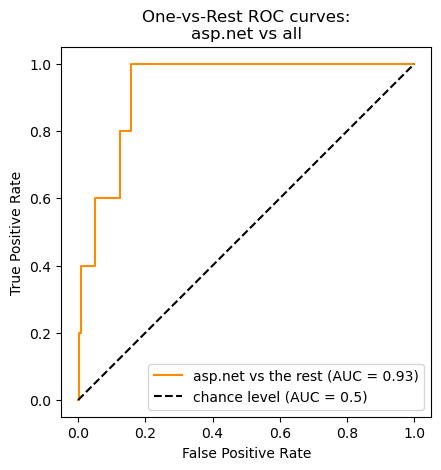

3


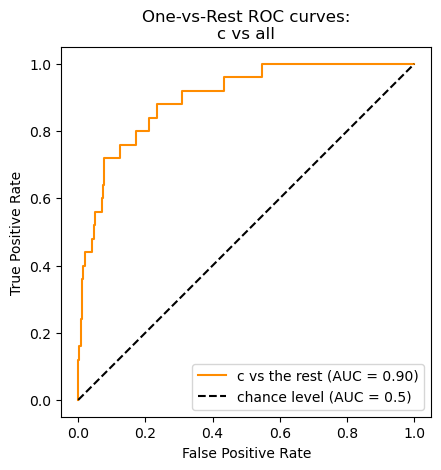

4


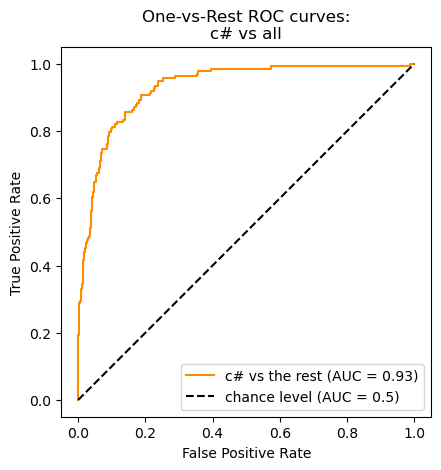

5


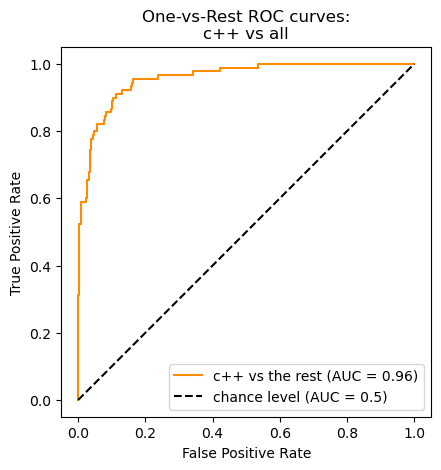

6


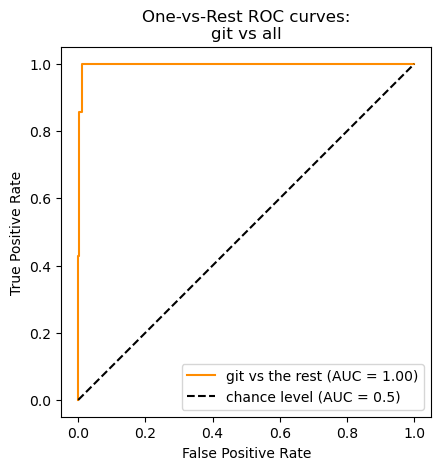

7


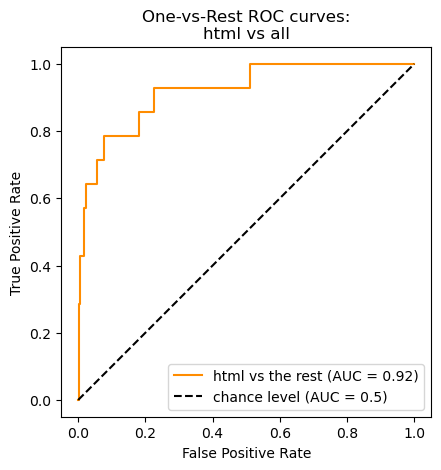

8


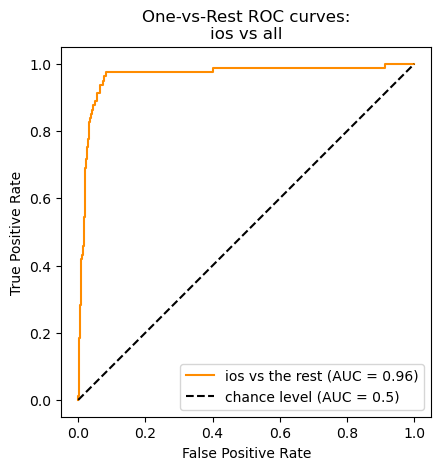

9


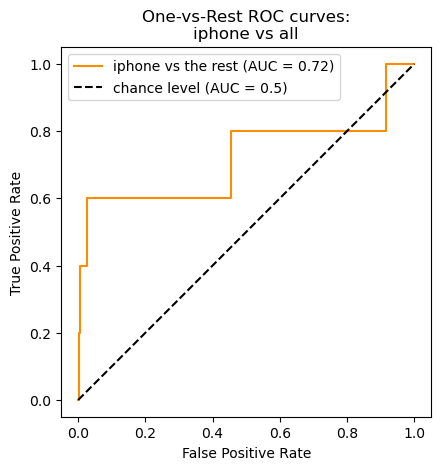

10


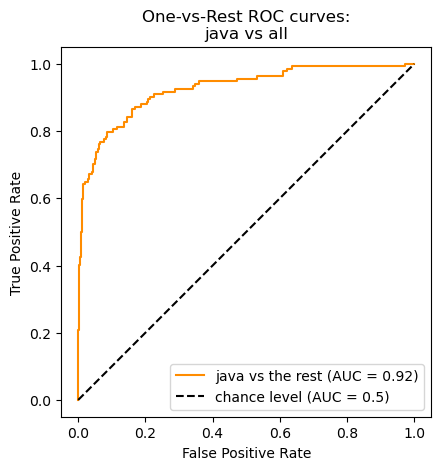

11


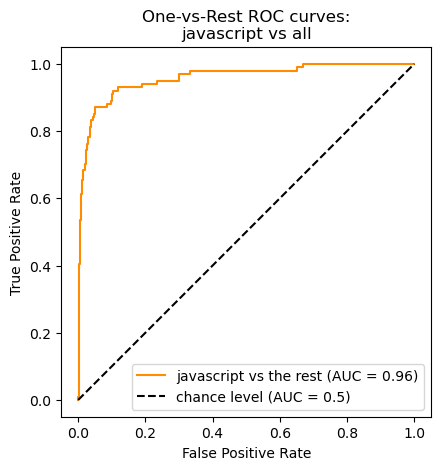

12


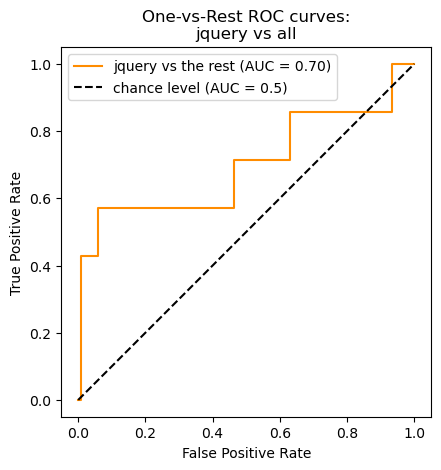

13


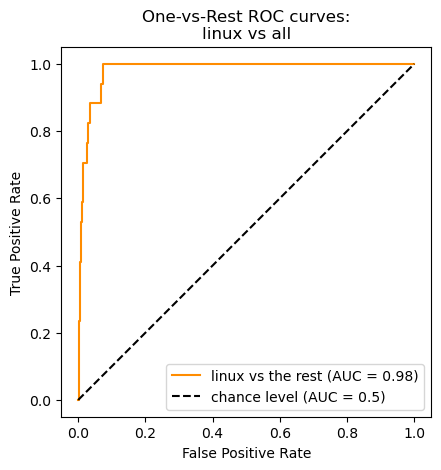

14


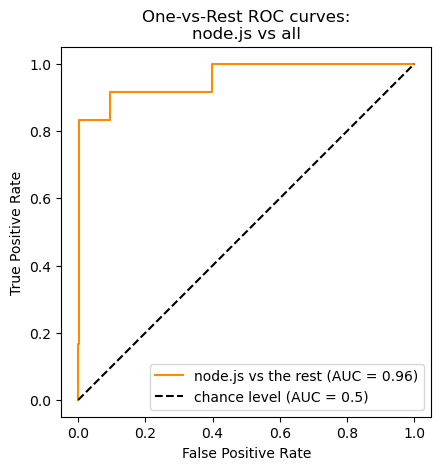

15


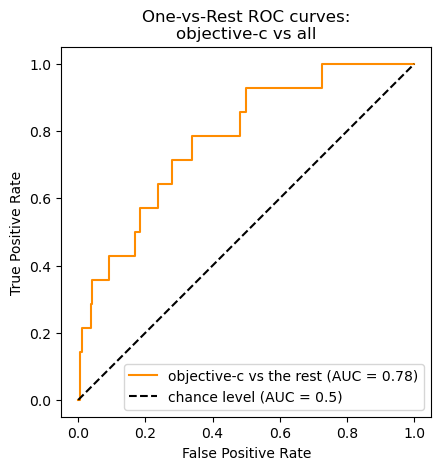

16


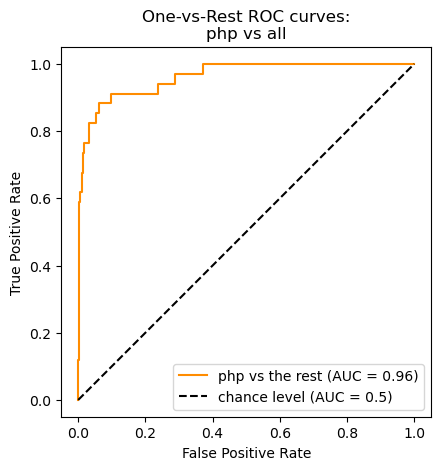

17


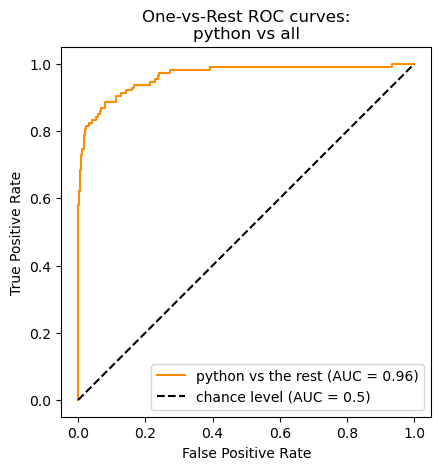

18


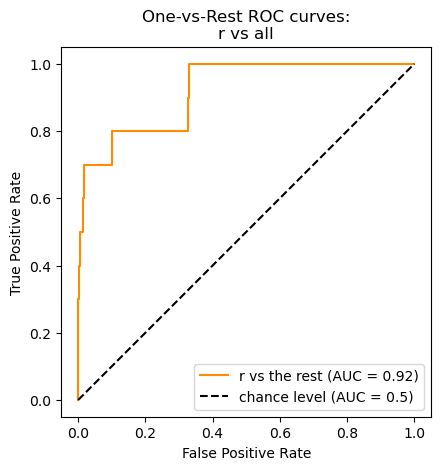

19


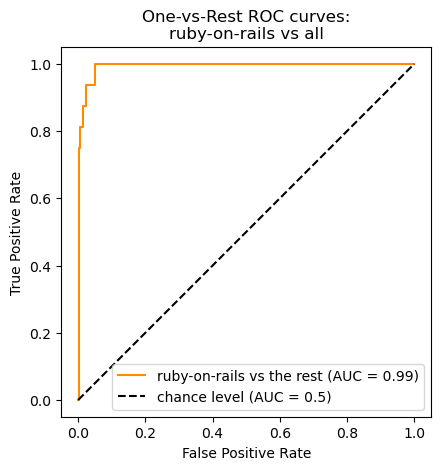

20


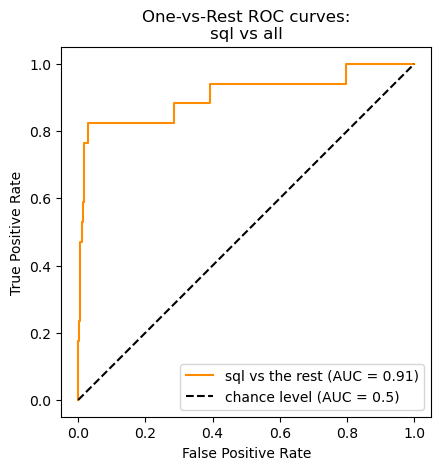

21


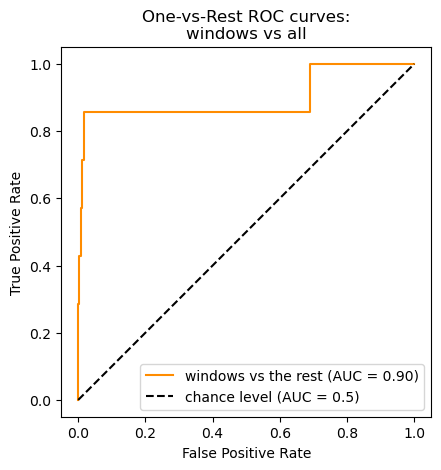

In [200]:
for class_id in label_binarizer.classes_:
    # Choose a specific class for showing the ROC curve
#    class_of_interest = "c#"
    class_of_interest = np.flatnonzero(label_binarizer.classes_ == class_id)[0]
    print(class_of_interest)
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_of_interest],
        y_score[:, class_of_interest],
        name=f"{class_id} vs the rest",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"One-vs-Rest ROC curves:\n{class_id} vs all")
    plt.legend()
    plt.show()



### Optimal Threshold for Precision-Recall Curve

In [201]:
# TEST CELL
y_score.shape

(927, 22)

In [202]:
len(y_onehot_test[:, tag_prediction][y_onehot_test[:, tag_prediction]==1])

7

In [212]:
best_thresholds = []
# pr curve for logistic regression model
for tag_prediction in range(0, y_score.shape[1]):

    # keep probabilities for the positive outcome only (minority class)
    yhat = y_score[:, tag_prediction]
    # calculate pr-curve
    precision, recall, thresholds = precision_recall_curve(y_onehot_test[:, tag_prediction], yhat)
    ...
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    if not math.isnan(fscore[ix]):
        best_thresholds.append(thresholds[ix])
        print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('Overall best threshold=%f'% np.mean(best_thresholds))

Best Threshold=0.215871, F-Score=0.748
Best Threshold=0.242604, F-Score=0.417
Best Threshold=0.468352, F-Score=0.696
Best Threshold=0.322206, F-Score=0.725
Best Threshold=0.081861, F-Score=0.750
Best Threshold=0.252697, F-Score=0.761
Best Threshold=0.592788, F-Score=0.741
Best Threshold=0.439052, F-Score=0.774
Best Threshold=0.164648, F-Score=0.833
Best Threshold=0.381248, F-Score=0.714
Best Threshold=0.314092, F-Score=0.825
Best Threshold=0.082739, F-Score=0.533
Best Threshold=0.080369, F-Score=0.565
Best Threshold=0.209157, F-Score=0.545
Overall best threshold=0.274835


/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_21482/2210728310.py:11: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)
/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_21482/2210728310.py:11: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)
/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_21482/2210728310.py:11: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)
/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_21482/2210728310.py:11: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)
/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_21482/2210728310.py:11: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)
/var/folders/xx/m7dpq0_56k9crn

If we are interested in a threshold that results in the best balance of precision and recall, then this is the same as optimizing the F(1)-measure that summarizes the harmonic mean of both measures.

    F-Measure = (2 * Precision * Recall) / (Precision + Recall)

As in the previous section, the naive approach to finding the optimal threshold would be to calculate the F-measure for each threshold. We can achieve the same effect by converting the precision and recall measures to F-measure directly; for example:

/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_21482/115405898.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


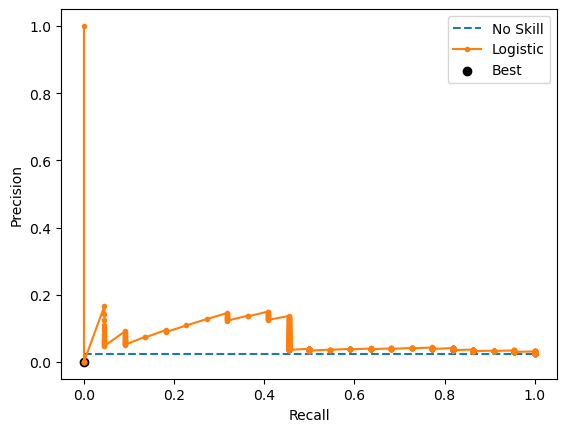

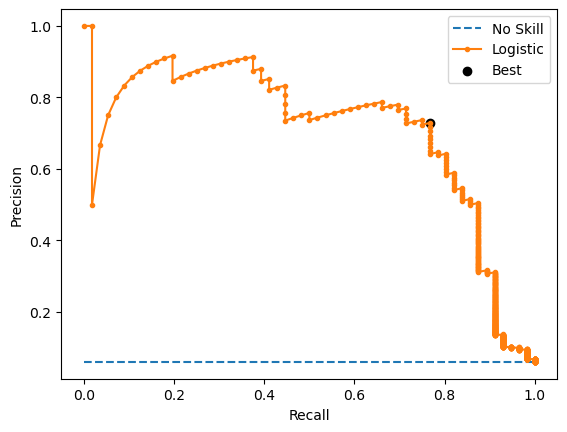

/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_21482/115405898.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


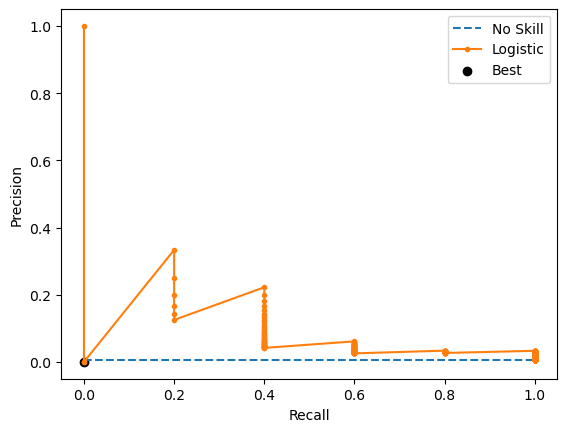

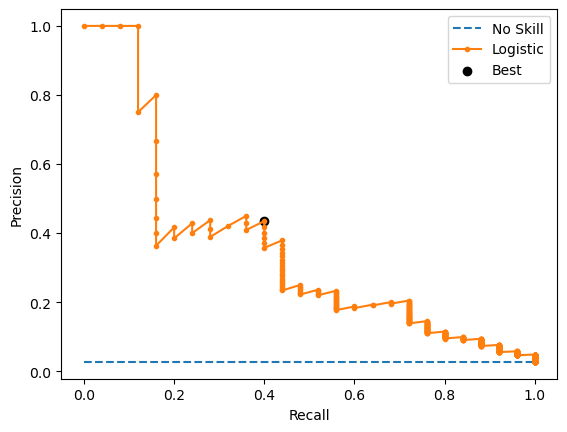

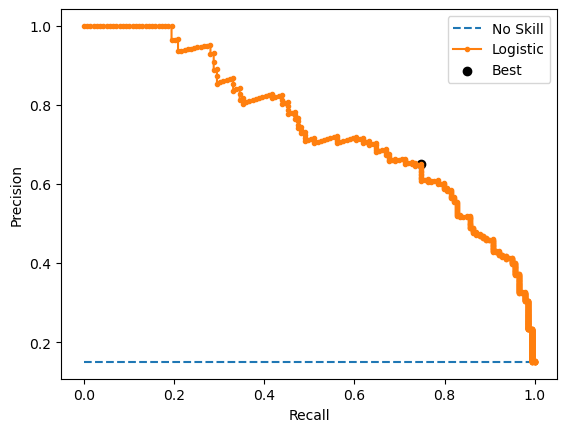

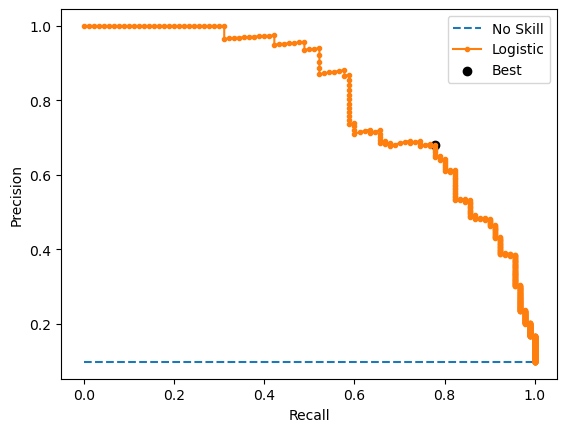

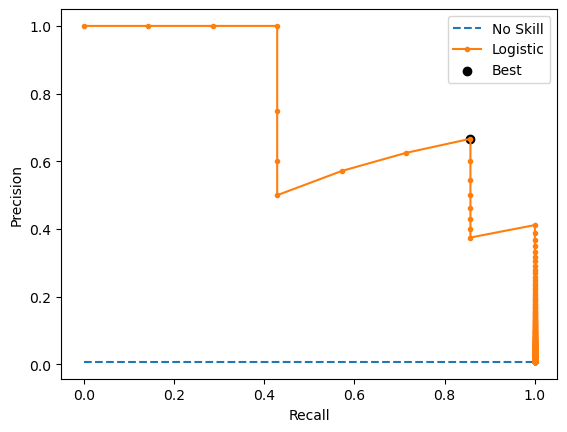

/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_21482/115405898.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


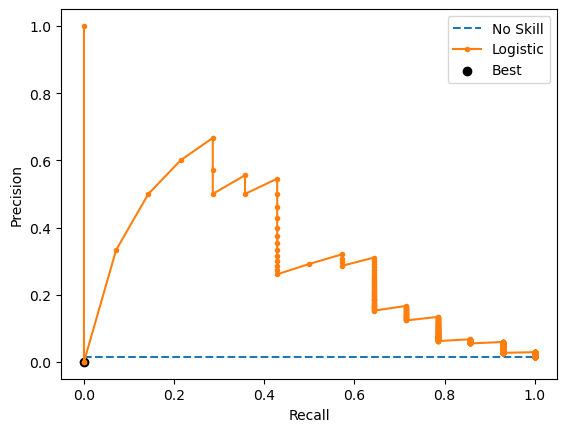

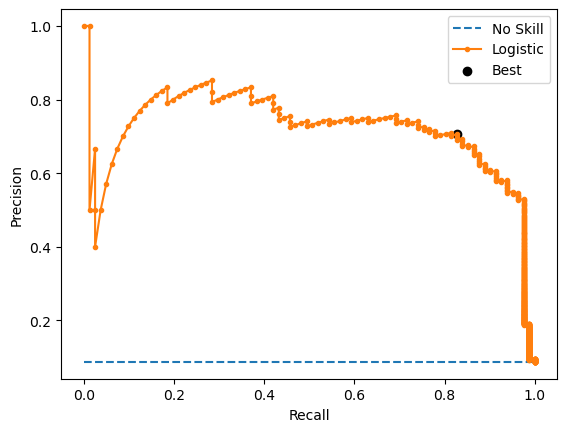

/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_21482/115405898.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


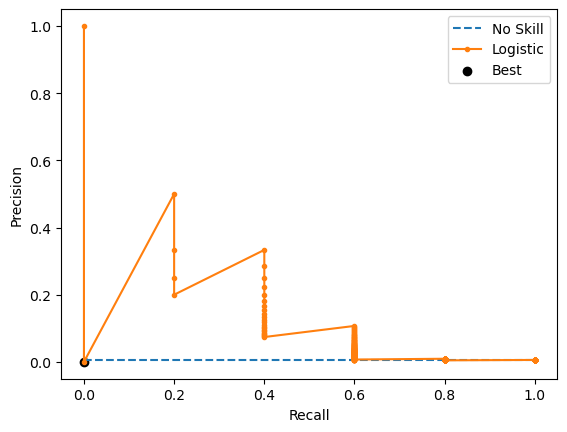

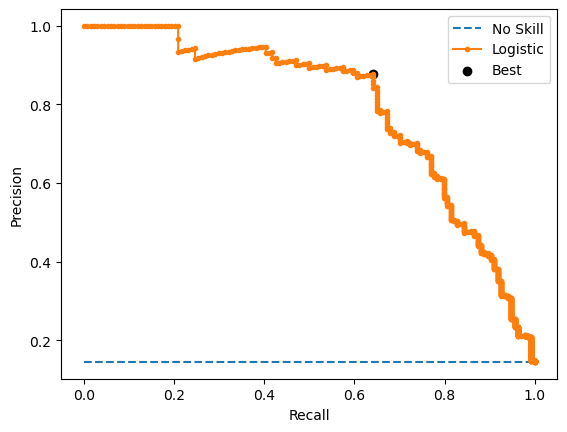

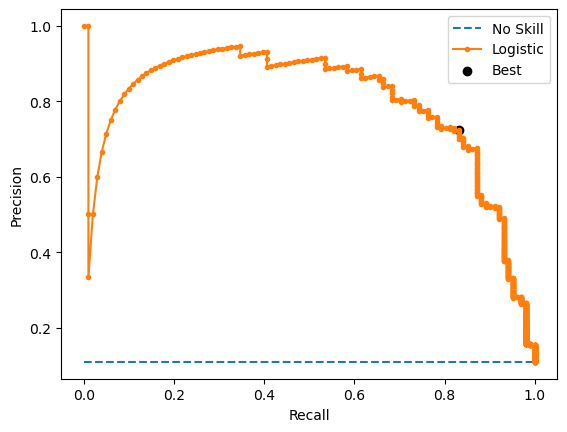

/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_21482/115405898.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


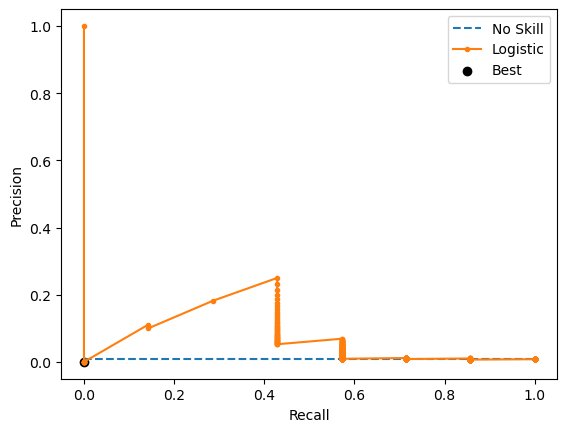

/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_21482/115405898.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


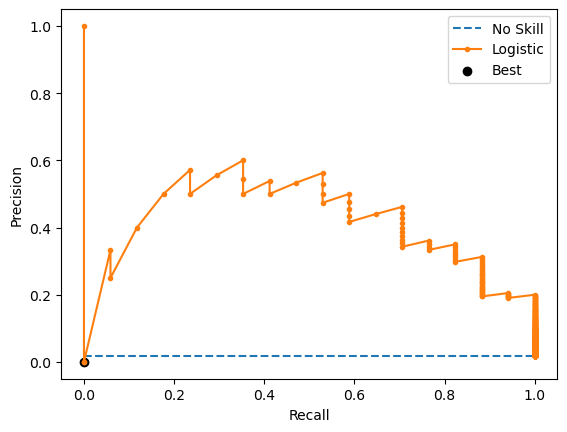

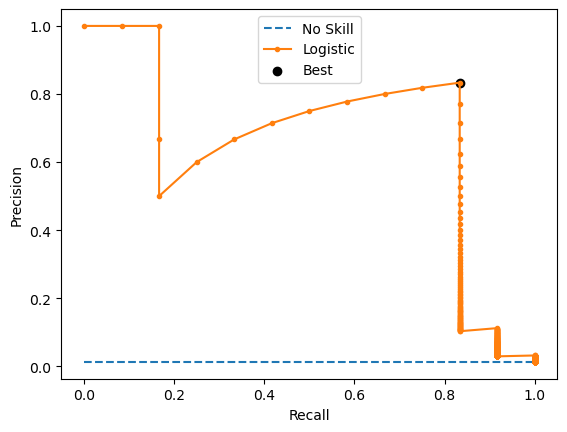

/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_21482/115405898.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


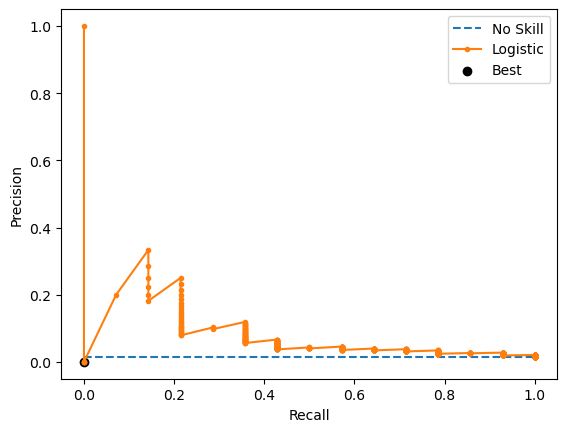

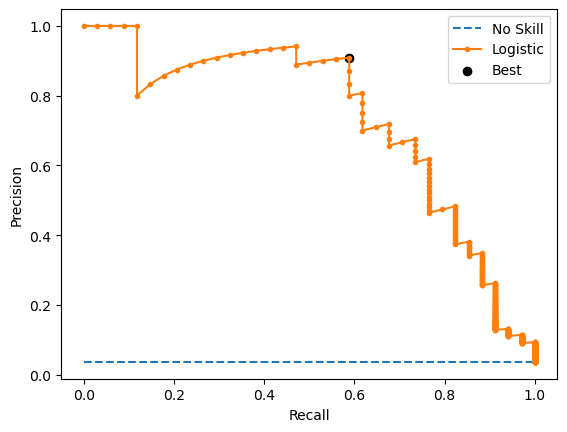

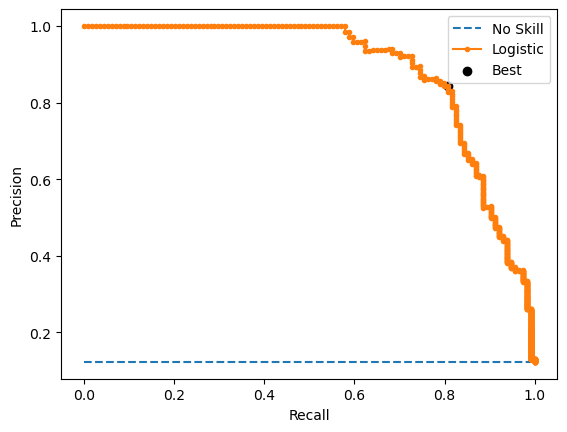

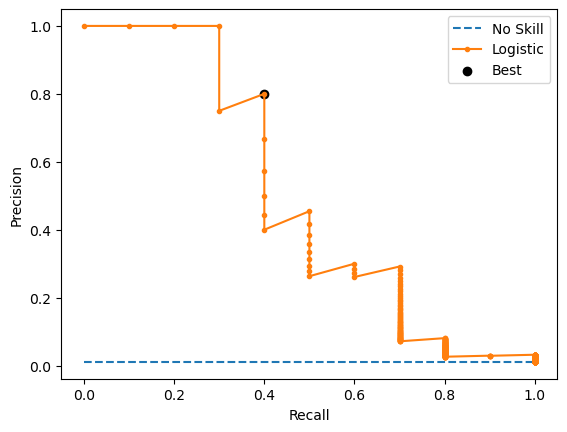

/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_21482/115405898.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


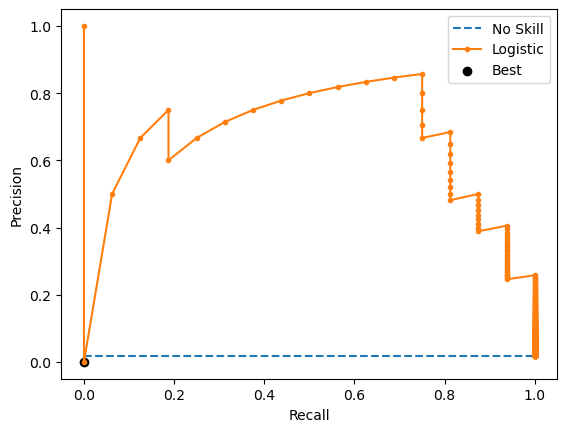

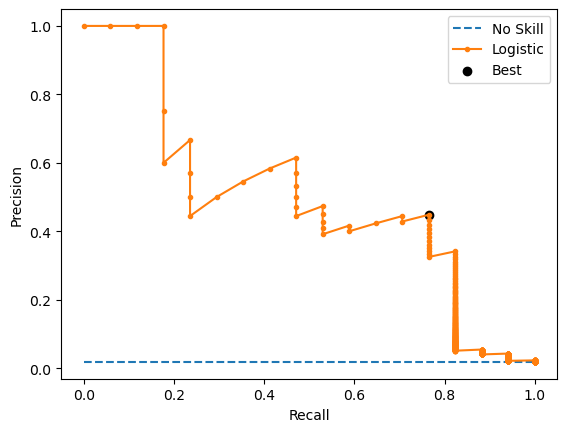

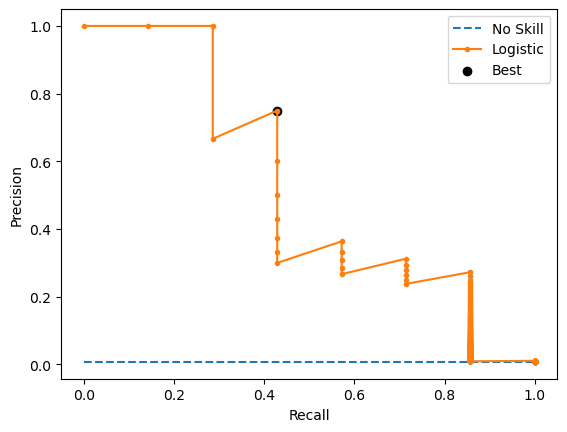

In [205]:
for tag_prediction in range(0, y_score.shape[1]):

    # keep probabilities for the positive outcome only (minority class)
    yhat = y_score[:, tag_prediction]
    # calculate pr-curve
    precision, recall, thresholds = precision_recall_curve(y_onehot_test[:, tag_prediction], yhat)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    # --------------------------- #
    # plot the roc curve for the model
    no_skill = len(y_onehot_test[:, tag_prediction][y_onehot_test[:, tag_prediction]==1]) / len(y_onehot_test[:])
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='Logistic')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()
    
    

In [5]:
# PREDICT PROBABILITIES WITH BEST THRESHOLDS
y_score_best_thresh = (cross_validated_lr.predict_proba(X_test_dense) > thresholds[ix]).astype('float')
y_score_best_thresh


NameError: name 'cross_validated_lr' is not defined

Remonter aux tags pour voir le nombre de tags associes dont la proba est superieure au threshold
Construire des vecteurs de 5, 10 ou 100 tags differents
Refaire en utilisant le meme dataset que pour le unsupervised...

In [4]:
y_score_best_thresh

NameError: name 'y_score_best_thresh' is not defined